# Loading Data

In [ ]:
!pip install pgeocode
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
#loadig the data
raw_data = pd.read_csv('/content/drive/MyDrive/MineriaProyecto/CPT_PREDICTIVE_PPM.csv',encoding='unicode_escape',low_memory=False)
raw_data['Date Created'] =  pd.to_datetime(raw_data['Date Created'])

raw_data['Date Created'] = raw_data['Date Created'].dt.to_period('M')

raw_data['month'] = raw_data['Date Created'].dt.month
raw_data['year'] = raw_data['Date Created'].dt.year

# Data Preparation

#### extracting store features

In [ ]:
store_features = raw_data[~raw_data['Site Number'].duplicated()][['Site Number','Site Type','Level 1 Organization Name','Site Zipcode','Sales Sq. Ft.']].sort_values(by='Site Number')

#adding number of refrigerators per store
ref_count  = raw_data.groupby('Site Number')['Asset Barcode'].nunique().to_frame()
store_features = store_features.merge(ref_count,how='inner',on = 'Site Number')
store_features = store_features.rename(columns ={'Asset Barcode':'refrigerators count'})

#getting location
store_features['Site Zipcode'] =store_features['Site Zipcode'].apply(lambda x: x.split()[0])

import pgeocode
geolocator = pgeocode.Nominatim('GB')

locations = geolocator.query_postal_code(store_features['Site Zipcode'].unique())
locations = locations[['postal_code','latitude','longitude']]

store_features = store_features.merge(locations, how = 'inner',left_on='Site Zipcode',right_on='postal_code')
store_features.drop(['postal_code', 'Site Zipcode'],axis =1,inplace=True)


In [ ]:
store_features

,Site Number,Site Type,Level 1 Organization Name,Sales Sq. Ft.,refrigerators count,latitude,longitude
0,A0002,SUPERMARKET,Region S04,11846.0,46,51.5333,0.000000
1,A4874,CONVENIENCE STORE,Region S04-2,NaN,10,51.5333,0.000000
2,A0003,SUPERMARKET,Region S02,37870.0,165,51.4349,0.351300
3,P0003,PFS,Region S02,NaN,2,51.4349,0.351300
4,A0004,SHARED SITE,Region S05,15490.0,42,51.3761,-0.541500
...,...,...,...,...,...,...,...
1621,D1229,DEPOT,Depot,NaN,1,51.2738,0.497000
1622,M0474,STORE SUPPORT CENTRE,Miscellaneous,NaN,1,52.4255,-1.459175
1623,P2038-N,PFS,Region N10,NaN,3,53.3860,-1.408467
1624,P2038-S,PFS,Region N10,NaN,3,53.3860,-1.408467


### Analizing NaN values in areas

In [ ]:
f = store_features['Sales Sq. Ft.'].copy()

f[~f.isna()] = 1
f[f.isna()] = 0
f

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
1621    0.0
1622    0.0
1623    0.0
1624    0.0
1625    0.0
Name: Sales Sq. Ft., Length: 1626, dtype: float64

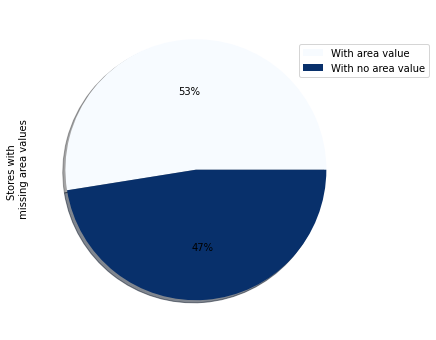

In [ ]:
ax = f.value_counts().plot(kind='pie', autopct='%1.0f%%',shadow=True, legend=True, ylabel='Stores with \n missing area values', labeldistance=None,cmap="Blues", figsize=(6,6))
ax.legend(bbox_to_anchor=(.8,.9), loc='upper left',labels=['With area value','With no area value'])

#### 53% of the stores don't have area values

In [ ]:
import seaborn as sns

In [ ]:
f = store_features['Site Number'].copy()

for i,j in zip(raw_data.groupby('Site Number')['Asset Barcode'].unique(),range(store_features['Site Number'].nunique())):
    if 'No Asset' in i:
        f[j]=0
    else: f[j]=1

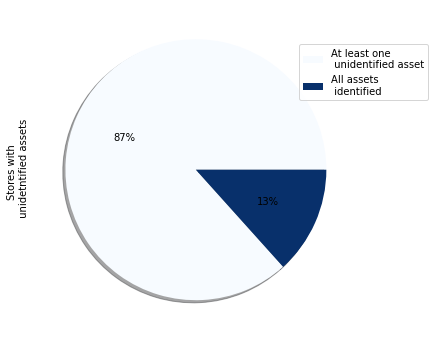

In [ ]:
ax = f.value_counts().plot(kind='pie', autopct='%1.0f%%',shadow=True, legend=True, ylabel='Stores with \n unidetntified assets', labeldistance=None,cmap="Blues", figsize=(6,6))
ax.legend(bbox_to_anchor=(.8,.9), loc='upper left',labels=['At least one \n unidentified asset','All assets \n identified'])

#### 87% of the stores have at leat one unidentified refrigerator

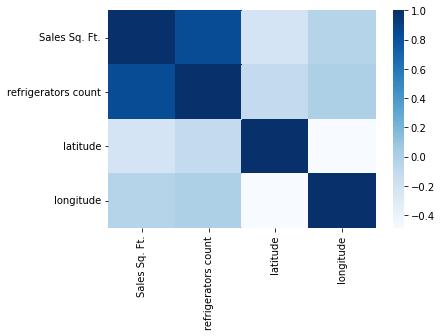

In [ ]:
# plot the heatmap
corr =store_features.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap="Blues")

#### Using the high correlation between ref count and store area to fill the missing area values

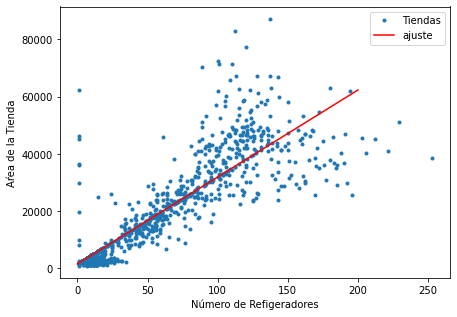

In [ ]:
# filling missing area values 
a = store_features['refrigerators count'].values
c = store_features['Sales Sq. Ft.']

#linear regression
coeff = np.polyfit(a[(~c.isna())],c[(~c.isna())].values,1)
xx = np.linspace(0,200,200)
yy = np.poly1d(coeff) 

#filling missing data without area
indxs = store_features[store_features['Sales Sq. Ft.'].isna()].index
store_features.iloc[indxs,3] = yy(store_features.iloc[indxs,4])


plt.figure(figsize=(7,5))
plt.plot(a,c,'.',label='Tiendas')
plt.plot(xx,yy(xx),'r-',label='ajuste')
plt.xlabel('Número de Refigeradores')
plt.ylabel('Aŕea de la Tienda')
plt.legend()

In [ ]:
store_features.drop('refrigerators count', axis=1,inplace=True)
store_features

,Site Number,Site Type,Level 1 Organization Name,Sales Sq. Ft.,latitude,longitude
0,A0002,SUPERMARKET,Region S04,11846.000000,51.5333,0.000000
1,A4874,CONVENIENCE STORE,Region S04-2,4571.616701,51.5333,0.000000
2,A0003,SUPERMARKET,Region S02,37870.000000,51.4349,0.351300
3,P0003,PFS,Region S02,2139.035481,51.4349,0.351300
4,A0004,SHARED SITE,Region S05,15490.000000,51.3761,-0.541500
...,...,...,...,...,...,...
1621,D1229,DEPOT,Depot,1834.962828,51.2738,0.497000
1622,M0474,STORE SUPPORT CENTRE,Miscellaneous,1834.962828,52.4255,-1.459175
1623,P2038-N,PFS,Region N10,2443.108133,53.3860,-1.408467
1624,P2038-S,PFS,Region N10,2443.108133,53.3860,-1.408467


## reducing cardinality of some store features


### Site Type

In [ ]:
categorical_columns = ['Site Number',
                      'Site Type',
                      'Level 1 Organization Name']

In [ ]:
for col in categorical_columns:
    n = store_features[col].nunique()
    if n<10: 
        print('{} has {} values ... : {}'.format(col,n,store_features[col].unique()))
    else:
        print('{} has {} values'.format(col,n))

Site Number has 1626 values
Site Type has 7 values ... : ['SUPERMARKET' 'CONVENIENCE STORE' 'PFS' 'SHARED SITE' 'DEPOT'
 'CENTRAL LOCATION' 'STORE SUPPORT CENTRE']
Level 1 Organization Name has 73 values


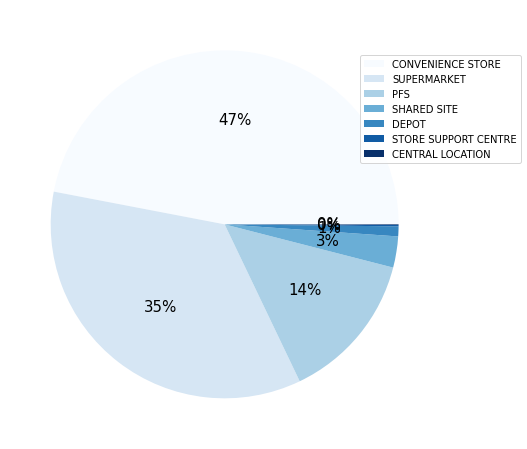

In [ ]:
ax = store_features['Site Type'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(8,8), legend=True, ylabel='', cmap="Blues",labeldistance=None,fontsize=15)
ax.legend(bbox_to_anchor=(.8,.9), loc='upper left')

In [ ]:
mask = store_features['Site Type'].map(store_features['Site Type'].value_counts(normalize=True)) < 0.10
store_features['Site Type'] =  store_features['Site Type'].mask(mask, 'other')

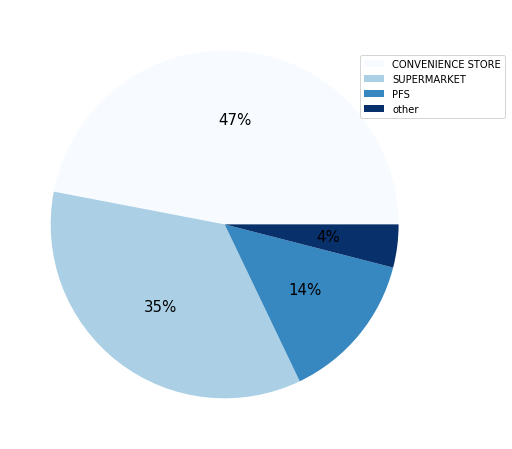

In [ ]:
ax = store_features['Site Type'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(8,8),legend=True, ylabel='',cmap="Blues", labeldistance=None,fontsize=15)
ax.legend(bbox_to_anchor=(.8,.9), loc='upper left')

### adding number of alarms:

In [ ]:
#getting number of alarms
data = raw_data.groupby(['Site Number','year', 'month'])['Work Order Number'].count()
data.unstack(level=0)

Site Number  A0002  A0003  A0004  A0005  A0006  A0007  A0008  A0009  A0011  \
year month                                                                   
2012 1        18.0   21.0   10.0    1.0   12.0   20.0   10.0   21.0   13.0   
     2         8.0   14.0    4.0    3.0    9.0    2.0    6.0   42.0   15.0   
     3         2.0    3.0    2.0   11.0    3.0   10.0   13.0   17.0   23.0   
     4         8.0    6.0    5.0    4.0    1.0    5.0    7.0    9.0   15.0   
     5         6.0   29.0    4.0   10.0   12.0   18.0   16.0   27.0   24.0   
     6         8.0   26.0    3.0    9.0    2.0   17.0   21.0   10.0   17.0   
     7         9.0   39.0    5.0   17.0    7.0   19.0   24.0  145.0   21.0   
     8        36.0   38.0    7.0    7.0    8.0   17.0   26.0  126.0   20.0   
     9         3.0   21.0    2.0    6.0    5.0   11.0   23.0   10.0    6.0   
     10       10.0   55.0    8.0    7.0   14.0   18.0   12.0   14.0   12.0   
     11        6.0   23.0    2.0   11.0    3.0   15.0    5.0    9.0   10.0   
     12        8.0   87.0   12.0    6.0    6.0    5.0   29.0    7.0   27.0   
2013 1        15.0   31.0    4.0    7.0   26.0   17.0   14.0   43.0   19.0   
     2         1.0   41.0    5.0    9.0   16.0   11.0   17.0   31.0   22.0   
     3         9.0   37.0   11.0   32.0   32.0   11.0   10.0   25.0    9.0   
     4        12.0   44.0   10.0   13.0    8.0   20.0   14.0   23.0   41.0   
     5        13.0   57.0   11.0    7.0   19.0   14.0   10.0   26.0   19.0   
     6         9.0   34.0   12.0   20.0   45.0   17.0    5.0   62.0   26.0   
     7        16.0   78.0   28.0   58.0   75.0   28.0   33.0  214.0   70.0   
     8        11.0   50.0   22.0    8.0   15.0   20.0   49.0   68.0   42.0   
     9        11.0   50.0   19.0   24.0   21.0    7.0   33.0   63.0   41.0   
     10       12.0   97.0   17.0   12.0   32.0   22.0   38.0   33.0   46.0   
     11        3.0   18.0   25.0   16.0   19.0   44.0   14.0   24.0   23.0   
     12        8.0   33.0   22.0   13.0   11.0   16.0   14.0   19.0    8.0   
2014 1        15.0   11.0   16.0   14.0   21.0   11.0    6.0   12.0   20.0   
     2        15.0   33.0   23.0   12.0   13.0    7.0    9.0    8.0   28.0   
     3        17.0   27.0   17.0   19.0   12.0   12.0   26.0   26.0   34.0   
     4        18.0   23.0    4.0   10.0    8.0   16.0   13.0    6.0   37.0   
     5        12.0   47.0    7.0   11.0   13.0   47.0   18.0   11.0   22.0   
     6         5.0   43.0    7.0   25.0   11.0   26.0   19.0   14.0   13.0   
     7        13.0   56.0    7.0   15.0   29.0   53.0   20.0   33.0   39.0   
     8        11.0   32.0   15.0    9.0   10.0   15.0   19.0   13.0   18.0   
     9        11.0   52.0    5.0   20.0   13.0   26.0   22.0    8.0   20.0   
     10       13.0   32.0    7.0   14.0   15.0   20.0   79.0    7.0   17.0   
     11        6.0   52.0    2.0   12.0   18.0   29.0   11.0   10.0   29.0   
     12        6.0   24.0    8.0   20.0   24.0    8.0   11.0    4.0   12.0   
2015 1        11.0   22.0    7.0   12.0   11.0   19.0   18.0   26.0   37.0   
     2        13.0   54.0    8.0   20.0   21.0   12.0   10.0   28.0   11.0   
     3        15.0   37.0    4.0   16.0   17.0   20.0   15.0    9.0   38.0   
     4        13.0   36.0    9.0   31.0   23.0   20.0   12.0   12.0   21.0   
     5        21.0   34.0   11.0   20.0   25.0    9.0   12.0    5.0   17.0   
     6        15.0   44.0    3.0    8.0   33.0   29.0   12.0    7.0   22.0   
     7        18.0   41.0    NaN   14.0   85.0    7.0   15.0    6.0   30.0   
     8         7.0   65.0   14.0   17.0   47.0    9.0   17.0    9.0   31.0   
     9         5.0   24.0    3.0    8.0   21.0   16.0   14.0    6.0   26.0   
     10       17.0   21.0    4.0    8.0   33.0   14.0   23.0   10.0   24.0   
     11        6.0   10.0    2.0   11.0   14.0   10.0    5.0    2.0    8.0   
     12        3.0    8.0    3.0    7.0    6.0    4.0   12.0    7.0    4.0   

Site Number  A0014  ...  P2289  P2290  P2293  P2295  P2303  P2308  P2313  \
year month          ...

In [ ]:
data = data.reset_index()
#addign all the other features assosiated to the store
data = data.merge(store_features,how='outer',on = 'Site Number')

data = data.rename(columns ={'Work Order Number':'alarm count'})

#droping nan
data.dropna(axis=0,inplace=True) #these nan come from the location search

In [ ]:
data

,Site Number,year,month,alarm count,Site Type,Level 1 Organization Name,Sales Sq. Ft.,latitude,longitude
0,A0002,2012,1,18,SUPERMARKET,Region S04,11846.000000,51.5333,0.000
1,A0002,2012,2,8,SUPERMARKET,Region S04,11846.000000,51.5333,0.000
2,A0002,2012,3,2,SUPERMARKET,Region S04,11846.000000,51.5333,0.000
3,A0002,2012,4,8,SUPERMARKET,Region S04,11846.000000,51.5333,0.000
4,A0002,2012,5,6,SUPERMARKET,Region S04,11846.000000,51.5333,0.000
...,...,...,...,...,...,...,...,...,...
53653,P2835,2014,10,2,PFS,Region N07,3659.398744,53.5635,-2.378
53654,P2835,2014,11,3,PFS,Region N07,3659.398744,53.5635,-2.378
53655,P2835,2014,12,3,PFS,Region N07,3659.398744,53.5635,-2.378
53656,P2835,2015,4,2,PFS,Region N07,3659.398744,53.5635,-2.378


## reducing stores

#### Dropping  stores with less than 12 months of information

In [ ]:
mask = data['Site Number'].map(data.groupby(['Site Number'])['month'].count())<18
data[mask]['Site Number'].unique()

array(['A0070', 'A0412', 'A0724', 'A0738', 'A2031', 'A2069', 'A2083',
       'A2312', 'A2317', 'A2318', 'A2327', 'A2625', 'A2658', 'A2662',
       'A2708', 'A4004', 'A4016', 'A4124', 'A4129', 'A4140', 'A4148',
       'A4160', 'A4163', 'A4169', 'A4172', 'A4177', 'A4181', 'A4186',
       'A4225', 'A4227', 'A4260', 'A4273', 'A4275', 'A4300', 'A4301',
       'A4303', 'A4305', 'A4306', 'A4308', 'A4311', 'A4312', 'A4316',
       'A4317', 'A4320', 'A4321', 'A4322', 'A4327', 'A4328', 'A4329',
       'A4331', 'A4334', 'A4335', 'A4340', 'A4347', 'A4350', 'A4353',
       'A4357', 'A4360', 'A4371', 'A4382', 'A4389', 'A4390', 'A4391',
       'A4394', 'A4396', 'A4399', 'A4428', 'A4434', 'A4435', 'A4444',
       'A4451', 'A4462', 'A4468', 'A4485', 'A4492', 'A4533', 'A4537',
       'A4542', 'A4543', 'A4544', 'A4545', 'A4546', 'A4547', 'A4548',
       'A4549', 'A4550', 'A4551', 'A4552', 'A4554', 'A4555', 'A4556',
       'A4557', 'A4558', 'A4559', 'A4560', 'A4563', 'A4564', 'A4569',
       'A4570', 'A45

In [ ]:
data.drop(index=data[mask].index,inplace=True)

#### dropping stores without 2015 reports

In [ ]:
mask = data['Site Number'].map(data.groupby(['Site Number'])['year'].unique()).apply(lambda x: 2015 not in x)
data[mask].groupby(['Site Number'])['year'].unique()

Site Number
A0025    [2012, 2013, 2014]
A0225    [2012, 2013, 2014]
A0405          [2012, 2013]
A0824    [2012, 2013, 2014]
A0829    [2012, 2013, 2014]
A4109    [2012, 2013, 2014]
A4421    [2012, 2013, 2014]
A4902    [2012, 2013, 2014]
P0762    [2012, 2013, 2014]
P0867    [2012, 2013, 2014]
Name: year, dtype: object

In [ ]:
data.drop(index = data[mask].index,inplace=True)

In [ ]:
data['Site Number'].nunique()/raw_data['Site Number'].nunique()*100

78.59778597785979

#### We still got 78% of the stores

In [ ]:
data = data.sort_values(by=['year','month'])
data = data.reset_index().drop('index',axis=1)

# Applying model

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=6,
    gap=48,
    max_train_size=10000,
    test_size=1000)

In [ ]:
# Split data
X = data.drop('alarm count',axis='columns')
y = data['alarm count']/data['alarm count'].max()

In [ ]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]

# Different encodings to use with RidgeCV Linear Regressor

https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#time-based-cross-validation

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import RidgeCV
import numpy as np

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        error_score='raise'
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

### Naive linear 

In [ ]:
%%time
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)

naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.022 +/- 0.003
Root Mean Squared Error: 0.033 +/- 0.004
CPU times: user 1min 36s, sys: 17.5 s, total: 1min 53s
Wall time: 1min 2s


### Time-steps as categories

In [ ]:
%%time
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ['year','month']),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.024 +/- 0.005
Root Mean Squared Error: 0.035 +/- 0.005
CPU times: user 1min 39s, sys: 17.5 s, total: 1min 57s
Wall time: 1min 6s


### Cyclic Spline

In [ ]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [ ]:
%%time

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=12), ["month"]),
        ("cyclic_year", periodic_spline_transformer(24, n_splines=4), ["year"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.023 +/- 0.003
Root Mean Squared Error: 0.034 +/- 0.004
CPU times: user 1min 39s, sys: 17.3 s, total: 1min 56s
Wall time: 1min 3s


In [ ]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])

In [ ]:
naive_linear_pipeline[:-1].transform(X).shape

(50638, 1348)

In [ ]:
one_hot_linear_pipeline[:-1].transform(X).shape

(50638, 1357)

In [ ]:
cyclic_spline_linear_pipeline[:-1].transform(X).shape

(50638, 1362)

naive linear has the least mean absolute error and creates the least amount of features

### Trigonometric 

In [ ]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [ ]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("year_sin", sin_transformer(4), ["year"]),
        ("year_cos", cos_transformer(4), ["year"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.024 +/- 0.003
Root Mean Squared Error: 0.034 +/- 0.004


# Checking predictions

In [ ]:
n = .70 #percentage of data to split
x_train= X[:int(len(y)*n)]
x_test = X[int(len(y)*n):]
y_train= y[:int(len(y)*n)]
y_test = y[int(len(y)*n):]

### One hot

In [ ]:
one_hot_linear_pipeline.fit(x_train,y_train)
one_hot_linear_predictions = naive_linear_pipeline.predict(x_test)

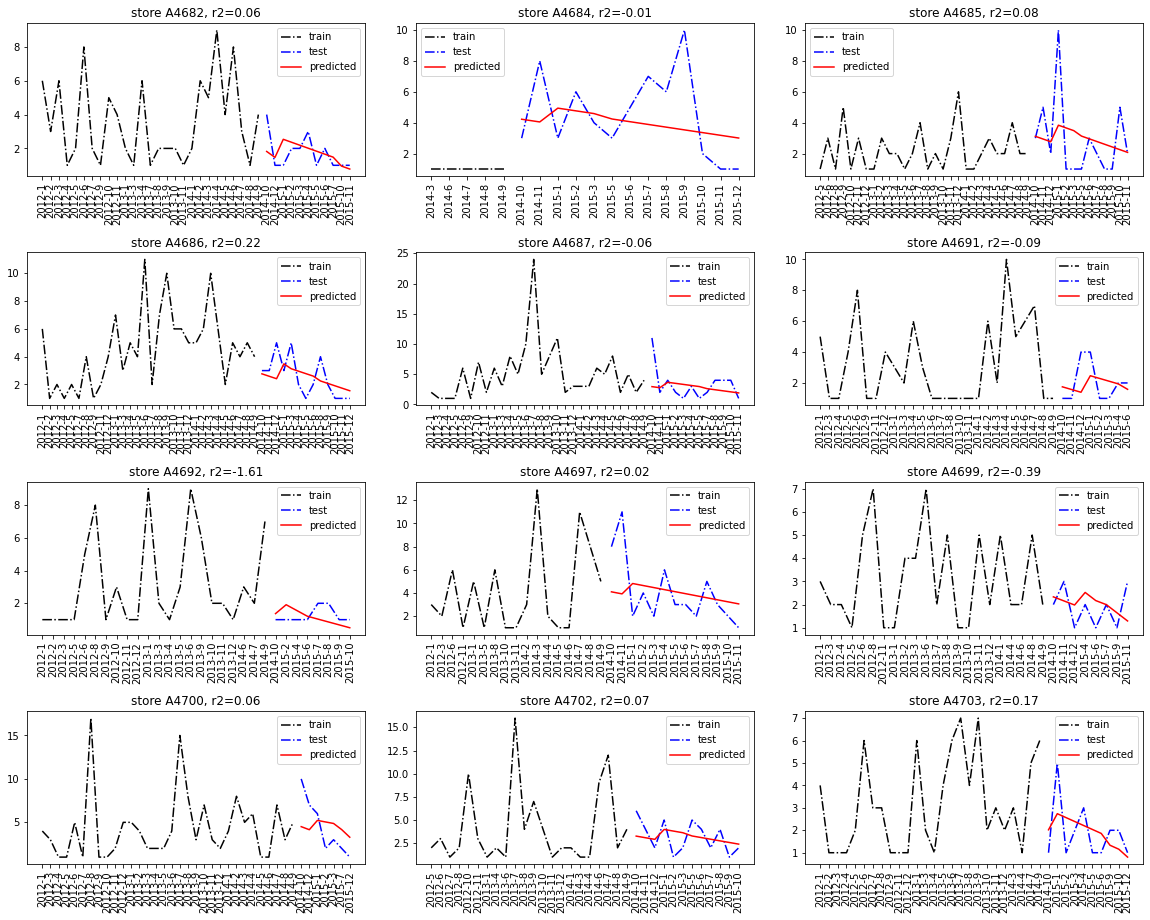

In [ ]:
# this is only so that i can plot a specific store

data_test = pd.concat([x_test,y_test],axis=1, join='outer')
data_train = pd.concat([x_train,y_train],axis=1, join='outer')
data_predicted = x_test.copy()

data_predicted['alarm count'] = one_hot_linear_predictions

data_test['Date Created'] = data_test[['year','month']].astype(str).apply('-'.join,axis=1)
data_train['Date Created'] = data_train[['year','month']].astype(str).apply('-'.join,axis=1)
data_predicted['Date Created'] = data_predicted[['year','month']].astype(str).apply('-'.join,axis=1)

# stores = np.random.choice(data_test['Site Number'].unique(),12)
stores = data_test['Site Number'].unique()[12:24]


fig, axes = plt.subplots(4,3,figsize=(20,16))
for ax,store in zip(axes.flat,stores):
    
    pred = data_predicted[data_predicted['Site Number'] == store]
    train= data_train[data_train['Site Number'] == store]
    test = data_test[data_test['Site Number'] == store]
    r2 =  metrics.r2_score(test['alarm count'],pred['alarm count'])

    ax.title.set_text('store %s, r2=%.2f' %(store,r2))
    ax.plot(train['Date Created'],train['alarm count']*data['alarm count'].max(),'k-.',label='train')
    ax.plot( test['Date Created'], test['alarm count']*data['alarm count'].max(),'b-.',label='test')
    ax.plot( pred['Date Created'], pred['alarm count']*data['alarm count'].max(),'r-',label='predicted')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=90)

    'P2244'

plt.subplots_adjust(bottom=0.15,wspace=0.15,hspace=0.5)



### naive_linear

In [ ]:
naive_linear_pipeline.fit(x_train,y_train)
naive_linear_predictions = naive_linear_pipeline.predict(x_test)

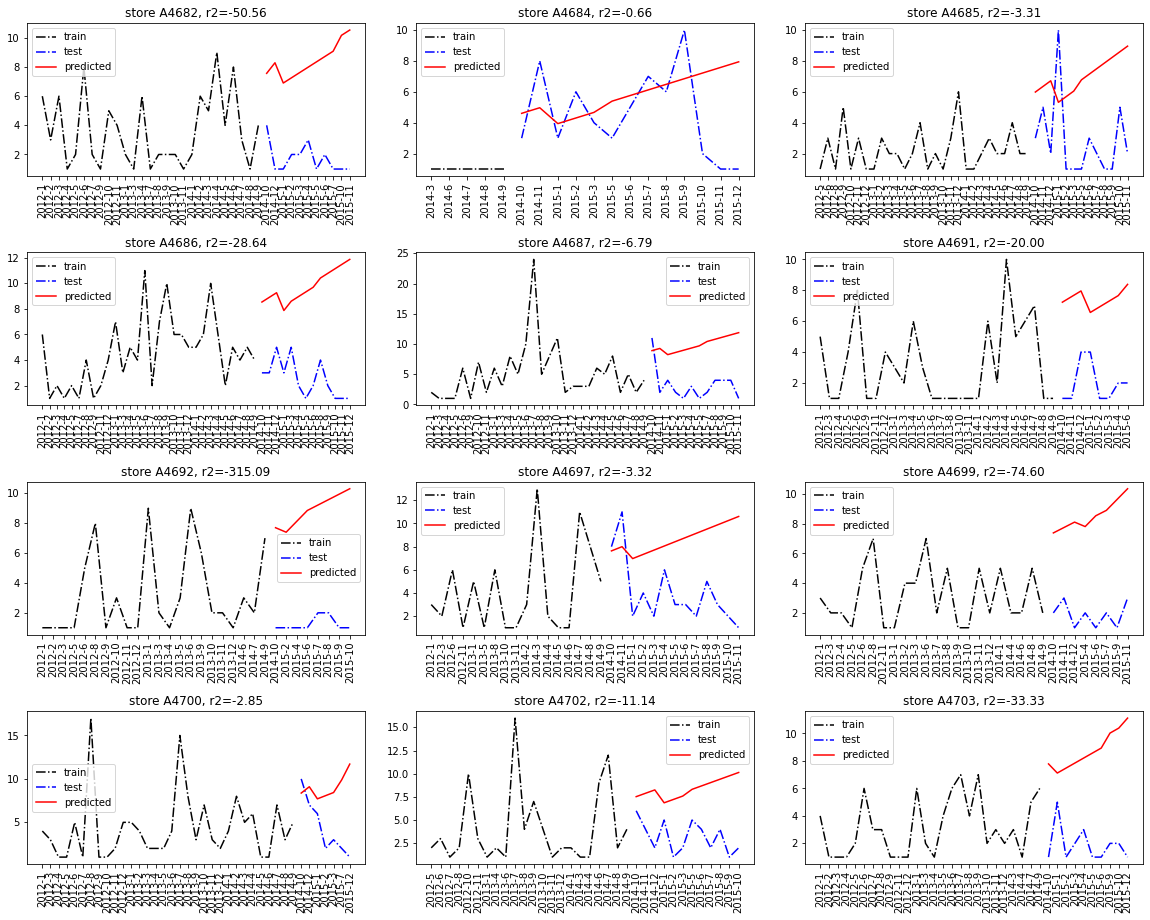

In [ ]:
# this is only so that i can plot a specific store

data_test = pd.concat([x_test,y_test],axis=1, join='outer')
data_train = pd.concat([x_train,y_train],axis=1, join='outer')
data_predicted = x_test.copy()

data_predicted['alarm count'] = naive_linear_predictions 

data_test['Date Created'] = data_test[['year','month']].astype(str).apply('-'.join,axis=1)
data_train['Date Created'] = data_train[['year','month']].astype(str).apply('-'.join,axis=1)
data_predicted['Date Created'] = data_predicted[['year','month']].astype(str).apply('-'.join,axis=1)

# stores = np.random.choice(data_test['Site Number'].unique(),12)
stores = data_test['Site Number'].unique()[12:24]


fig, axes = plt.subplots(4,3,figsize=(20,16))
for ax,store in zip(axes.flat,stores):
    
    pred = data_predicted[data_predicted['Site Number'] == store]
    train= data_train[data_train['Site Number'] == store]
    test = data_test[data_test['Site Number'] == store]
    r2 =  metrics.r2_score(test['alarm count'],pred['alarm count'])

    ax.title.set_text('store %s, r2=%.2f' %(store,r2))
    ax.plot(train['Date Created'],train['alarm count']*data['alarm count'].max(),'k-.',label='train')
    ax.plot( test['Date Created'], test['alarm count']*data['alarm count'].max(),'b-.',label='test')
    ax.plot( pred['Date Created'], pred['alarm count']*data['alarm count'].max(),'r-',label='predicted')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.subplots_adjust(bottom=0.15,wspace=0.15,hspace=0.5)

### Trigonometric

In [ ]:
cyclic_cossin_linear_pipeline.fit(x_train,y_train)
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(x_test)

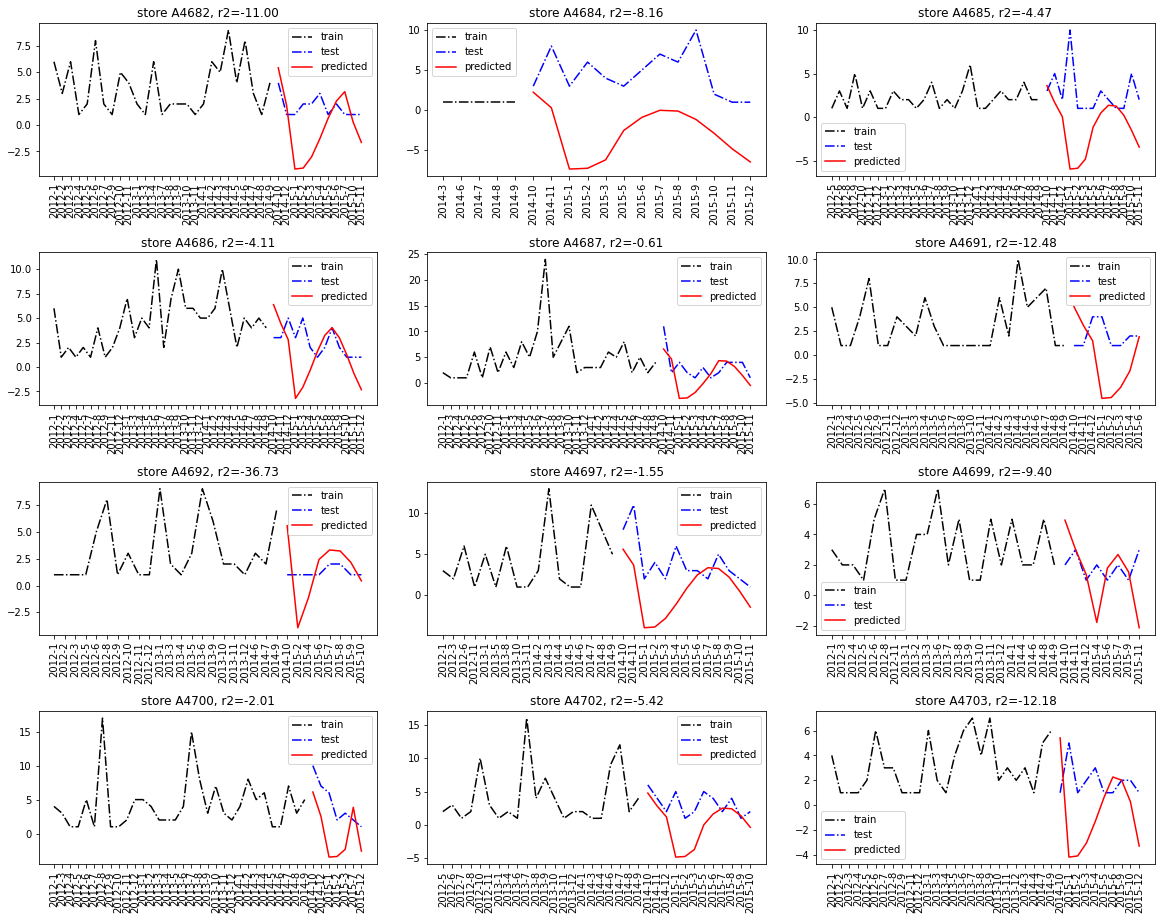

In [ ]:
# this is only so that i can plot a specific store

data_test = pd.concat([x_test,y_test],axis=1, join='outer')
data_train = pd.concat([x_train,y_train],axis=1, join='outer')
data_predicted = x_test.copy()

data_predicted['alarm count'] = cyclic_cossin_linear_predictions

data_test['Date Created'] = data_test[['year','month']].astype(str).apply('-'.join,axis=1)
data_train['Date Created'] = data_train[['year','month']].astype(str).apply('-'.join,axis=1)
data_predicted['Date Created'] = data_predicted[['year','month']].astype(str).apply('-'.join,axis=1)

# stores = np.random.choice(data_test['Site Number'].unique(),12)
stores = data_test['Site Number'].unique()[12:24]

fig, axes = plt.subplots(4,3,figsize=(20,16))
for ax,store in zip(axes.flat,stores):
    
    pred = data_predicted[data_predicted['Site Number'] == store]
    train= data_train[data_train['Site Number'] == store]
    test = data_test[data_test['Site Number'] == store]
    r2 =  metrics.r2_score(test['alarm count'],pred['alarm count'])

    ax.title.set_text('store %s, r2=%.2f' %(store,r2))
    ax.plot(train['Date Created'],train['alarm count']*data['alarm count'].max(),'k-.',label='train')
    ax.plot( test['Date Created'], test['alarm count']*data['alarm count'].max(),'b-.',label='test')
    ax.plot( pred['Date Created'], pred['alarm count']*data['alarm count'].max(),'r-',label='predicted')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.subplots_adjust(bottom=0.15,wspace=0.15,hspace=0.5)

### Cyclic Spline

In [ ]:
cyclic_spline_linear_pipeline.fit(x_train,y_train)
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(x_test)

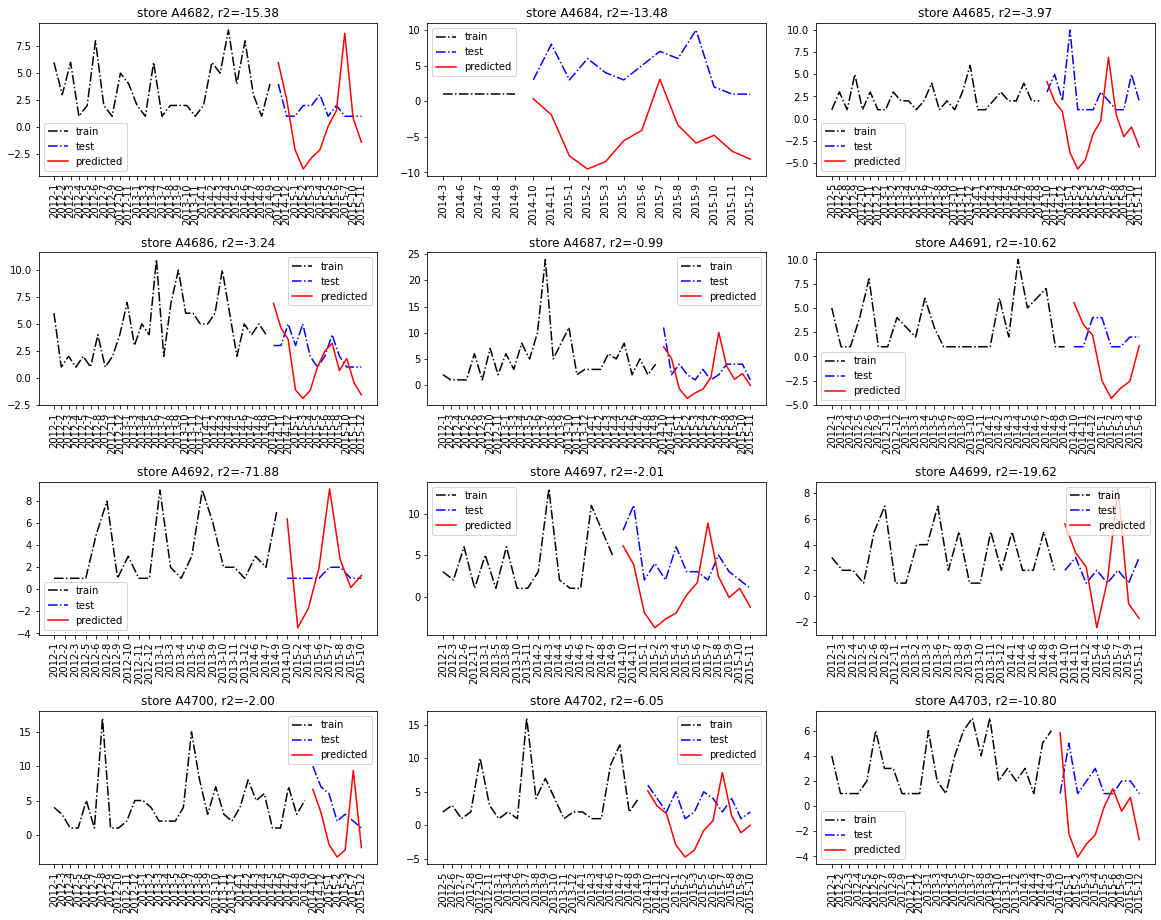

In [ ]:
# this is only so that i can plot a specific store

data_test = pd.concat([x_test,y_test],axis=1, join='outer')
data_train = pd.concat([x_train,y_train],axis=1, join='outer')
data_predicted = x_test.copy()

data_predicted['alarm count'] = cyclic_spline_linear_predictions

data_test['Date Created'] = data_test[['year','month']].astype(str).apply('-'.join,axis=1)
data_train['Date Created'] = data_train[['year','month']].astype(str).apply('-'.join,axis=1)
data_predicted['Date Created'] = data_predicted[['year','month']].astype(str).apply('-'.join,axis=1)

# stores = np.random.choice(data_test['Site Number'].unique(),12)
stores = data_test['Site Number'].unique()[12:24]

fig, axes = plt.subplots(4,3,figsize=(20,16))
for ax,store in zip(axes.flat,stores):
    
    pred = data_predicted[data_predicted['Site Number'] == store]
    train= data_train[data_train['Site Number'] == store]
    test = data_test[data_test['Site Number'] == store]
    r2 =  metrics.r2_score(test['alarm count'],pred['alarm count'])

    ax.title.set_text('store %s, r2=%.2f' %(store,r2))
    ax.plot(train['Date Created'],train['alarm count']*data['alarm count'].max(),'k-.',label='train')
    ax.plot( test['Date Created'], test['alarm count']*data['alarm count'].max(),'b-.',label='test')
    ax.plot( pred['Date Created'], pred['alarm count']*data['alarm count'].max(),'r-',label='predicted')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=90)

plt.subplots_adjust(bottom=0.15,wspace=0.15,hspace=0.5)